In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import copy
import warnings
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import scikitplot as skplt
import warnings
pd.options.display.float_format = '{:,.2f}'.format
from datetime import timedelta
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 1000)


# Initial Data Analysis
### Note - Checking the shape, size, and NA values in the dataset

In [2]:
df_train = pd.read_csv('/Users/lakshyagarg/Desktop/Dell/CaseStudy/CaseStudyData/Train.csv')

In [3]:
print ('Shape of the dataset:')
df_train.shape

Shape of the dataset:


(355311, 21)

In [4]:
print ('Datatypes in the dataset:')
df_train.dtypes

Datatypes in the dataset:


Sale                          float64
Quote                         float64
Segment                        object
Order_Dt                       object
Arrive_by_dt                   object
Brand                          object
Product                        object
Ship_City                      object
Ship_state                     object
Paym_term                      object
sku_lead_tm                   float64
Qty                             int64
order_amt                     float64
deliver_dt                     object
prvlg_ship_mode                object
prvlg_build_fac                object
prvlg_ship_fac                 object
prvlg_in_prod_dt               object
prvlg_ship_dt                  object
prvlg_expected_delivery_dt     object
prvlg_updated_delivery_dt      object
dtype: object

In [5]:
print ('Variable with NA values, their count, and percentages')
null_values = df_train.isna().sum().sort_values(ascending = False).to_frame().reset_index(inplace = False)
null_values.columns = ['Column_name','Numbers_of_null']
null_values['percentage']  = round( (null_values['Numbers_of_null']/df_train.shape[0])*100,2)
null_values

Variable with NA values, their count, and percentages


,Column_name,Numbers_of_null,percentage
0,Arrive_by_dt,352221,99.13
1,Quote,50551,14.23
2,sku_lead_tm,17552,4.94
3,prvlg_updated_delivery_dt,15749,4.43
4,prvlg_ship_dt,79,0.02
5,prvlg_in_prod_dt,11,0.00
6,Order_Dt,0,0.00
7,deliver_dt,0,0.00
8,prvlg_expected_delivery_dt,0,0.00
9,prvlg_ship_fac,0,0.00


# Changing date data types

In [6]:
# Changing date time to correct datatypes & dealing with bad values
def datatype_date_change(df_train, data_flag):
    # Data_flag captures whether we are passing training or test set
    if data_flag == 0:
        df_train['Order_Dt'] = pd.to_datetime(df_train['Order_Dt'] , format = '%m/%d/%Y')

        df_train['Arrive_by_dt'] = pd.to_datetime(df_train['Arrive_by_dt'] , format = '%m/%d/%Y')

        df_train['deliver_dt'] = pd.to_datetime(df_train['deliver_dt'] , format = '%m/%d/%Y')

        df_train['prvlg_in_prod_dt'] = pd.to_datetime(df_train['prvlg_in_prod_dt'] , format = '%m/%d/%Y')

        df_train['prvlg_ship_dt'] = pd.to_datetime(df_train['prvlg_ship_dt'] , format = '%m/%d/%Y')

        # print ('Bad values in prvlg_expected_delivery_dt:', df_train[df_train['prvlg_expected_delivery_dt'] == '1897-09-10'].shape)
        df_train['prvlg_expected_delivery_dt'] = df_train['prvlg_expected_delivery_dt'].replace({"1897-09-10": np.nan})
        df_train['prvlg_expected_delivery_dt'] = pd.to_datetime(df_train['prvlg_expected_delivery_dt'] , format = '%m/%d/%Y')

        # print ('Bad values in prvlg_updated_delivery_dt:', df_train[df_train['prvlg_updated_delivery_dt'] == -22].shape)
        df_train['prvlg_updated_delivery_dt'] = df_train['prvlg_updated_delivery_dt'].replace({"-22": np.nan})
        df_train['prvlg_updated_delivery_dt'] = pd.to_datetime(df_train['prvlg_updated_delivery_dt'] , format = '%m/%d/%Y')

    elif data_flag == 1:
        df_train['Order_Dt'] = pd.to_datetime(df_train['Order_Dt'] , format = '%m/%d/%Y')

        df_train['Arrive_by_dt'] = pd.to_datetime(df_train['Arrive_by_dt'] , format = '%m/%d/%Y')
        
    return df_train


In [7]:
# Applying transformations defined above to the training set
df_train = datatype_date_change(df_train,0)

# Creating the target variable that to predict as a regression problem

In [8]:
df_train['target_variable'] = (df_train['deliver_dt'] - df_train['Order_Dt']).dt.days

# Looking at column distribution 
### For categorical, Continious, and date columns

In [9]:
categorical_columns = ['Segment', 'Brand', 'Product','Ship_City','Ship_state','Paym_term','prvlg_ship_mode', 'prvlg_build_fac', 'prvlg_ship_fac']

for i in categorical_columns:
    print ('########################')
    print ('Number of distinct values present in each column for column:',i)
    print (df_train.groupby([i]).size().reset_index().sort_values(by=[0], ascending = [False]))
    print ('Unique entries in the dataset:', len(df_train[i].unique()))


########################
Number of distinct values present in each column for column: Segment
                             Segment       0
11  c3976246348c686e4deca0a7e331a039  117489
6   62ec0553902c09a0651064e81375217d   56703
15  d7ef4d1d66d2ae83faa9aa6383a6f65e   41456
16  d8856a306e76cdec5c33ddb4195c185d   28126
3   436f49abaa9ead4944c0757c875ad7bd   24508
7   79238f4ec268203867a0d6847b3c2846   23866
9   a4208583167ef20b778a2d29a13c11c3   17187
19  faf5ba2f1b7d5118474e600e23a8740b    9808
0   1fbba56b742b0e0b652bb11bc56e71bb    9739
14  d7aab7da9aa8282da8108fbb1e8a8dff    7142
5   4f8f76dfe9030964584b50fefc1d3edb    5297
2   38d88f729574954acf9ce56f97cc50fd    4615
13  d4d4102d1671f635c274ea64ee263571    3830
1   2089cf8b6194305d2c0df02faa5a1360    3641
10  ab2baa560815f58c2d9b6f41063c7e9c    1653
12  c9df4a0502e88a2ad37d308e50791331     110
4   43ea3ecaf7e8befaee10e6b6f9c54caf      64
17  ddbb933bd08d204995a0b6d3cc14386b      61
18  e9e79f285f957213396340936dfb0df7      11
8   99

Unique entries in the dataset: 7
########################
Number of distinct values present in each column for column: prvlg_ship_fac
                     prvlg_ship_fac       0
0  334dfb1ef5fc623374b835e11383d8a0  176767
7  c9f6ff0d507cbe7ca0ea07e4c88a1880   76277
4  82f1724d93a668a5800a91973e3115f2   40591
6  b249c002fd5910a8e608ffc14dd9e4d3   39821
5  ad8ea24b78598a945973ce7e2f0e7f93    8167
1  3fec0c44738c8fb9619e0b35641e66b6    6929
3  4663be1ec2bd099ee73a069f740707a4    6064
2  454a2ff79c3fff8327628dcc4b724f9a     695
Unique entries in the dataset: 8


###########################################
Columne name Sale mean, min, and max:
count       355,311.00
mean    852,022,492.22
std     128,232,397.82
min     301,944,380.00
25%     838,059,068.50
50%     878,006,874.00
75%     913,615,559.50
max     950,657,548.00
Name: Sale, dtype: float64

 Column name Sale density plot:


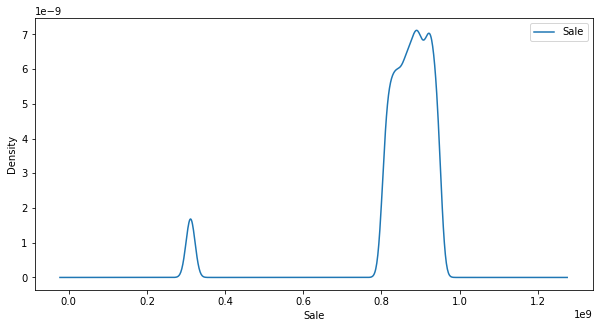

###########################################
Columne name Quote mean, min, and max:
count             304,760.00
mean    2,301,907,421,716.68
std     1,034,203,571,898.38
min                   425.00
25%     1,024,440,000,000.00
50%     3,000,080,000,000.00
75%     3,000,090,000,000.00
max     3,000,090,000,000.00
Name: Quote, dtype: float64

 Column name Quote density plot:


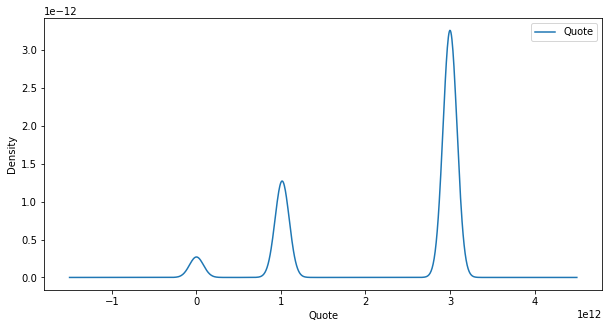

###########################################
Columne name sku_lead_tm mean, min, and max:
count   337,759.00
mean         21.80
std          18.73
min          -5.00
25%           9.00
50%          20.00
75%          30.00
max         100.00
Name: sku_lead_tm, dtype: float64

 Column name sku_lead_tm density plot:


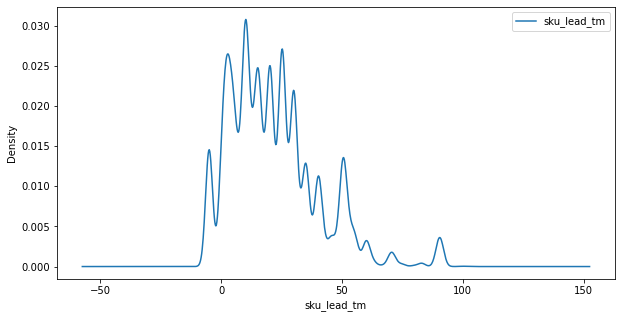

###########################################
Columne name Qty mean, min, and max:
count   355,311.00
mean          9.54
std          15.85
min           1.00
25%           1.00
50%           2.00
75%           6.00
max          78.00
Name: Qty, dtype: float64

 Column name Qty density plot:


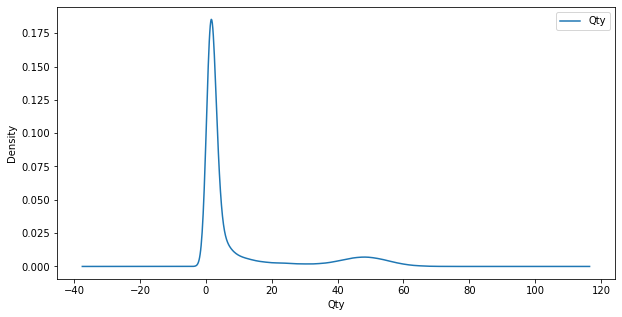

###########################################
Columne name order_amt mean, min, and max:
count   355,311.00
mean      9,601.00
std      17,183.08
min           1.90
25%       1,246.61
50%       1,787.15
75%       7,183.01
max     345,466.18
Name: order_amt, dtype: float64

 Column name order_amt density plot:


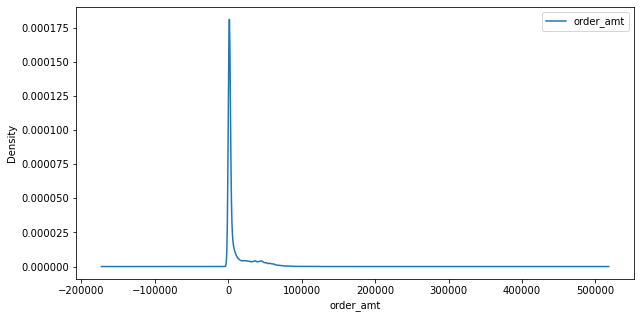

In [10]:
continious_columns = ['Sale','Quote','sku_lead_tm','Qty','order_amt']

## Distribution plot
for i in continious_columns:
    print ('###########################################')
    print ('Columne name {} mean, min, and max:'.format(i))
    print (df_train[i].describe())
    print ('\n Column name {} density plot:'.format(i))
    plt.figure(figsize=(10,5))
    plt.xlabel(i)
    plt.ylabel('Density')
    df_train[i].plot(kind='kde')
    plt.legend()
    plt.show()

In [11]:
date_columns = ['Order_Dt','Arrive_by_dt', 'deliver_dt','prvlg_in_prod_dt', 'prvlg_ship_dt','prvlg_expected_delivery_dt','prvlg_updated_delivery_dt']
for i in date_columns:
    print ('Column name:',i)
    print ('Maximum date present in the column:', df_train[i].max())
    print ('Minimum date present in the column:', df_train[i].min())
    print ('########################')

Column name: Order_Dt
Maximum date present in the column: 2019-04-11 00:00:00
Minimum date present in the column: 2018-09-12 00:00:00
########################
Column name: Arrive_by_dt
Maximum date present in the column: 2019-10-12 00:00:00
Minimum date present in the column: 2018-09-30 00:00:00
########################
Column name: deliver_dt
Maximum date present in the column: 2019-10-01 00:00:00
Minimum date present in the column: 2018-09-16 00:00:00
########################
Column name: prvlg_in_prod_dt
Maximum date present in the column: 2019-08-19 00:00:00
Minimum date present in the column: 2018-09-12 00:00:00
########################
Column name: prvlg_ship_dt
Maximum date present in the column: 2019-09-29 00:00:00
Minimum date present in the column: 2018-09-15 00:00:00
########################
Column name: prvlg_expected_delivery_dt
Maximum date present in the column: 2019-09-27 00:00:00
Minimum date present in the column: 2007-07-21 00:00:00
########################
Column na

# Dealing with NA & Bad values

In [12]:
def na_values(df_train):
    
    # Imputing missing values with mean as mean is a decent approximation of the missing value
    # Iterative imputer can also be used for advanced predcitive based imputation
    df_train['Quote'] =  df_train['Quote'].fillna(df_train['Quote'].mean())
    
    # As 18,100 values had sku term less than zero replacing them as zero assuming negative here means
    # that the part is already available at the factory
    df_train['sku_lead_tm'] = df_train['sku_lead_tm'].apply(lambda x: 0 if x < 0 else x)
    df_train['sku_lead_tm'] = df_train['sku_lead_tm'].fillna(df_train['sku_lead_tm'].mean())
    
    return df_train


In [13]:
df_train = na_values(df_train)

# Feature engineering

In [14]:
# I have not taken priviliged information in feature engineering as during prediction this will not be available
# ,but this can be used heuristically if we decide not to go ahead with a ML depolyement to do the following:
# 1. Track delivery times (deliver_dt - ship_dt) at each shipment facility
# 2. Track order backlog (ship_dt - order_dt) at shipment + building facility 
# 3. Create dynamic metric to track the % of times updated_delivery_dt excceded expected_delivery_dt

In [15]:
def feature_engineering(df_train):
    df_training_set = df_train[['Quote', 'Segment', 'Order_Dt', 'Arrive_by_dt', 'Brand', 'Product', 'Ship_City', 'Ship_state', 'Paym_term', 'sku_lead_tm', 'Qty', 'order_amt']]
    # Creating additional month, year, day columns form order date column
    df_training_set['Order_dt_day'] = df_training_set['Order_Dt'].dt.day
    df_training_set['Order_dt_month'] = df_training_set['Order_Dt'].dt.month
    df_training_set['Order_dt_year'] = df_training_set['Order_Dt'].dt.year
    
    # Creating a function to get week of month from day
    def week_of_month(x):
        x = int(x)
        a = 0
        if x >= 0 and x < 7:
            a = 1
        elif x >= 7 and x < 14:
            a = 2
        elif x >= 14 and x < 21:
            a = 3
        else:
            a = 4
        return a
    
    df_training_set['week_of_month'] = df_training_set['Order_dt_day'].apply(week_of_month)
    
    # Dropping Arrive_by_dt as more than 99% of the entries are NA & additional columns
    df_training_set = df_training_set.drop(['Order_Dt','Order_dt_day',
                                                'Arrive_by_dt']
                                               , axis = 'columns')

    
    return df_training_set
    

In [16]:
df_training_set = feature_engineering(df_train)

# Performing Label encoding

In [17]:
# Defining the encoder
def label_encode_columns(df, columns, encoders=None):
    if encoders is None:
        encoders = {}

        for col in columns:
            unique_values = list(df[col].unique())
            unique_values.append('Unseen')
            le = LabelEncoder().fit(unique_values)
            df[col] = le.transform(df[[col]])
            encoders[col] = le

    else:
        for col in columns:
            le = encoders.get(col)
            df[col] = [x if x in le.classes_ else 'Unseen' for x in df[col]]
            df[col] = le.transform(df[col])

    return df, encoders

In [18]:
categorical_columns_to_change = ['Segment', 'Brand', 'Product','Ship_City','Ship_state','Paym_term']  
# Using the encoder defined above to perform encoding on the training set
df_training_set,encoder = label_encode_columns(df_training_set,categorical_columns_to_change, None)

# Modeling

In [19]:
df_training_set.head(10)

,Quote,Segment,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,Order_dt_month,Order_dt_year,week_of_month
0,"2,301,907,421,716.68",12,12,5,3368,8,24,30.00,10,"8,448.01",3,2019,4
1,"1,017,820,000,000.00",17,47,45,8041,15,37,5.00,1,"1,115.07",10,2018,2
2,"3,000,090,000,000.00",12,22,16,7630,8,13,30.00,2,"1,142.85",2,2019,4
3,"1,029,690,000,000.00",6,12,5,4855,8,5,30.00,1,"1,574.38",2,2019,1
4,"3,000,080,000,000.00",7,19,26,6289,31,13,46.00,2,"1,285.22",1,2019,2
5,"1,022,860,000,000.00",12,22,16,7168,19,24,35.00,2,"1,068.16",2,2019,1
6,"1,024,190,000,000.00",17,47,45,6101,9,13,15.00,3,"1,595.45",11,2018,1
7,"3,000,090,000,000.00",7,22,16,4649,20,6,22.06,1,"1,560.28",3,2019,2
8,"3,000,080,000,000.00",0,42,2,3685,23,6,3.00,46,"20,962.20",11,2018,3
9,"2,301,907,421,716.68",3,47,45,4285,17,8,30.00,1,"1,938.41",3,2019,4


In [20]:
X = df_training_set
y = df_train['target_variable']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(284248, 13)
(284248,)
(71063, 13)
(71063,)


In [23]:
print ('Final rows ro column ration:',X_train.shape[0]/ X_train.shape[1] )
# As the rows / column ration is grater than 10 going ahead with a tree based approach still makes sense
# For model scoring metric I am using neg_root_mean_squared_error as we should penalize the model for making
# occasional big errors, which would not be achieved via neg_mean_absolute_error metric

Final rows ro column ration: 21865.23076923077


# Random forest regressor

In [24]:
NFOLDS = 3
NROWS = None

rfc = RandomForestRegressor(random_state = 42)

rf_params = {
    'n_jobs': [-1],
    'n_estimators': [200,400],
    'max_features': [0.6,0.9],
    'max_depth': [10,15],
    'min_samples_leaf': [100,500,1000]
}

In [25]:
clf_rf = GridSearchCV(rfc, rf_params, cv = NFOLDS, scoring='neg_root_mean_squared_error')
# clf_rf = BayesSearchCV(rfc, rf_params, n_iter = 1, cv = 3, scoring='neg_root_mean_squared_error', random_state=123)
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 15], 'max_features': [0.6, 0.9],
                         'min_samples_leaf': [100, 500, 1000],
                         'n_estimators': [200, 400], 'n_jobs': [-1]},
             scoring='neg_root_mean_squared_error')

In [26]:
print (clf_rf.best_score_)
print (clf_rf.best_params_)
print (clf_rf.best_estimator_)
random_forest_all_results = (pd.DataFrame(clf_rf.cv_results_))

-15.747047518215735
{'max_depth': 15, 'max_features': 0.9, 'min_samples_leaf': 100, 'n_estimators': 400, 'n_jobs': -1}
RandomForestRegressor(max_depth=15, max_features=0.9, min_samples_leaf=100,
                      n_estimators=400, n_jobs=-1, random_state=42)


In [27]:
# Retraining the RF regressor on the best hyperparameters post grid search
clf_tuned_rf = clf_rf.best_estimator_
clf_tuned_rf.fit(X_train, y_train)
y_pred_rf = clf_tuned_rf.predict(X_test)

In [28]:
rms_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print ('The root mean square error is:', round(rms_rf,2))

The root mean square error is: 15.28


In [29]:
X_test_rf = copy.deepcopy(X_test)
X_test_rf['Actual_delivery_day'] = y_test
X_test_rf['estimated_delivery_days'] = y_pred_rf
X_test_rf['pred_act_dif'] = abs(X_test_rf['Actual_delivery_day'] - X_test_rf['estimated_delivery_days'].apply(np.ceil))

## Post training results from random forest regressor

In [30]:
X_test_rf.sort_values(by=['pred_act_dif'], ascending = [True]).head(10)

,Quote,Segment,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,Order_dt_month,Order_dt_year,week_of_month,Actual_delivery_day,estimated_delivery_days,pred_act_dif
257676,"3,000,090,000,000.00",12,24,66,7537,46,24,5.00,1,"1,309.32",3,2019,2,32,31.80,0.00
119223,"3,000,080,000,000.00",5,30,54,5936,7,40,1.00,1,100.37,10,2018,3,13,12.93,0.00
238838,"3,000,080,000,000.00",6,42,2,4740,3,13,3.00,3,"5,003.32",12,2018,3,14,13.27,0.00
207643,"1,021,660,000,000.00",12,35,62,6934,7,13,0.00,1,"1,429.52",10,2018,3,13,12.53,0.00
39033,"2,301,907,421,716.68",17,11,36,654,9,8,3.00,3,"1,117.74",11,2018,2,14,13.13,0.00
158453,"3,000,090,000,000.00",12,33,48,3338,16,5,0.00,3,"1,698.77",3,2019,4,7,6.45,0.00
196342,"755,404,631.00",10,22,46,6462,12,51,22.06,1,909.89,12,2018,1,20,19.58,0.00
312164,"1,001,800,000,000.00",12,41,14,2172,50,13,0.00,2,"1,120.95",12,2018,3,6,5.37,0.00
253997,"1,001,770,000,000.00",12,22,16,3577,17,24,25.00,1,"1,481.19",3,2019,2,36,35.92,0.00
153663,"3,000,090,000,000.00",12,12,5,2675,37,13,0.00,42,"51,007.20",3,2019,1,20,19.14,0.00


In [31]:
X_test_rf.sort_values(by=['pred_act_dif'], ascending = [True]).iloc[20000:20010]

,Quote,Segment,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,Order_dt_month,Order_dt_year,week_of_month,Actual_delivery_day,estimated_delivery_days,pred_act_dif
342380,"3,000,090,000,000.00",12,22,16,2079,50,24,30.00,1,"1,462.42",2,2019,2,51,47.25,3.00
144077,"2,301,907,421,716.68",17,12,5,2397,22,8,35.00,1,"2,751.06",3,2019,2,85,81.16,3.00
129844,"1,030,930,000,000.00",6,19,26,3415,17,13,21.00,24,"34,421.16",12,2018,2,25,27.08,3.00
336284,"3,000,080,000,000.00",12,47,45,5190,8,13,5.00,2,"1,397.55",10,2018,3,19,15.71,3.00
54910,"2,301,907,421,716.68",12,38,49,4667,27,40,10.00,6,91.59,11,2018,2,19,15.68,3.00
291985,"3,000,080,000,000.00",12,38,49,2930,20,13,15.00,3,"3,947.08",9,2018,4,17,13.80,3.00
207147,"1,001,820,000,000.00",14,14,42,4267,10,8,16.00,2,259.18,4,2019,1,20,22.68,3.00
138699,"1,001,810,000,000.00",12,22,16,3577,17,24,30.00,1,"1,490.88",3,2019,1,29,31.14,3.00
261587,"3,000,080,000,000.00",12,33,48,7564,42,6,41.00,1,"1,283.46",1,2019,3,53,49.74,3.00
271899,"3,000,090,000,000.00",12,22,16,35,27,6,25.00,3,"1,033.69",2,2019,3,46,42.94,3.00


In [32]:
X_test_rf.sort_values(by=['pred_act_dif'], ascending = [True]).iloc[35000:35010]

,Quote,Segment,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,Order_dt_month,Order_dt_year,week_of_month,Actual_delivery_day,estimated_delivery_days,pred_act_dif
223109,"3,000,080,000,000.00",15,22,16,931,19,24,10.00,19,"21,804.05",11,2018,4,16,20.17,5.00
204506,"755,454,143.00",10,6,52,387,12,1,22.06,40,"41,329.74",12,2018,2,42,46.77,5.00
12759,"2,301,907,421,716.68",3,0,0,1789,41,8,15.00,2,"1,630.71",3,2019,1,12,16.27,5.00
251377,"3,000,080,000,000.00",16,12,5,5985,22,13,20.00,3,"1,494.49",10,2018,4,15,19.57,5.00
219412,"1,025,660,000,000.00",12,7,58,6586,8,13,22.00,2,"5,392.64",11,2018,1,15,19.98,5.00
315056,"3,000,080,000,000.00",17,41,14,3571,4,13,2.00,10,"16,277.74",9,2018,3,9,13.02,5.00
224205,"3,000,080,000,000.00",7,19,26,5844,7,40,16.00,2,213.64,12,2018,4,15,19.93,5.00
259031,"2,301,907,421,716.68",12,38,49,7268,39,24,20.00,1,879.59,9,2018,4,15,19.27,5.00
316280,"2,301,907,421,716.68",12,38,49,6068,37,40,35.00,3,87.50,10,2018,3,24,28.55,5.00
87885,"2,301,907,421,716.68",3,38,49,7112,47,8,9.00,1,"1,990.75",12,2018,4,10,14.79,5.00


In [33]:
X_test_rf.sort_values(by=['pred_act_dif'], ascending = [False]).head(10)

,Quote,Segment,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,Order_dt_month,Order_dt_year,week_of_month,Actual_delivery_day,estimated_delivery_days,pred_act_dif
175158,"755,443,408.00",10,43,60,3053,12,35,22.06,45,"58,380.86",12,2018,2,260,65.41,194.00
217494,"3,000,080,000,000.00",5,30,54,1600,8,13,6.00,2,"1,270.47",9,2018,4,216,26.88,189.00
133982,"3,000,080,000,000.00",11,33,48,6987,6,13,66.00,54,"60,445.15",11,2018,3,253,72.14,180.00
176029,"3,000,080,000,000.00",12,22,16,4116,10,13,13.00,41,"34,307.77",12,2018,4,207,30.28,176.00
199363,"3,000,080,000,000.00",12,12,5,2918,10,13,30.00,1,"1,396.13",12,2018,2,203,32.18,170.00
25578,"3,000,080,000,000.00",5,12,5,6559,51,13,2.00,57,"52,203.75",11,2018,2,197,26.54,170.00
261233,"3,000,080,000,000.00",12,22,16,7653,7,13,13.00,18,"34,022.38",12,2018,4,193,30.00,162.00
91616,"756,131,699.00",10,12,47,4399,12,50,22.06,2,"2,514.33",2,2019,1,193,31.60,161.00
215642,"3,000,080,000,000.00",16,19,26,4706,0,13,21.00,3,"1,311.22",12,2018,3,181,24.16,156.00
83531,"3,000,080,000,000.00",12,22,16,8145,8,13,13.00,2,"3,549.66",12,2018,4,182,26.11,155.00


# Overall evaulation metrics Random Forest

In [34]:
print ('On an average we are off by:',round(X_test_rf['pred_act_dif'].mean(),2))
print ('Mean of actual delivery date:', round(X_test_rf['Actual_delivery_day'].mean(),2))
print ('50% of times our estimate is off by less than or equal to:',X_test_rf['pred_act_dif'].median())

On an average we are off by: 9.43
Mean of actual delivery date: 36.71
50% of times our estimate is off by less than or equal to: 6.0


# XG Boost forest regressor

In [35]:
xgbr_grid = {
    'n_estimators': [250, 350],
    'max_depth': [12,20,28],
    'min_child_weight':[100,500,1000],
    'subsample': [0.6, 1],
    'lambda':[100,1000],
    'alpha': [100,1000]
    }

In [36]:
xgbr = xgb.XGBRegressor(random_state=42)

In [37]:
# clf_xg = GridSearchCV(xgbr, xgbr_grid, cv = 3, scoring='neg_root_mean_squared_error')
clf_xg = BayesSearchCV(xgbr, xgbr_grid, n_iter = 60, cv = 3, scoring='neg_root_mean_squared_error', random_state=123)
clf_xg.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                       

In [38]:
print (clf_xg.best_score_)
print (clf_xg.best_params_)
print (clf_xg.best_estimator_)
xg_boost_all_results = (pd.DataFrame(clf_xg.cv_results_))

-12.76986501110755
OrderedDict([('alpha', 100), ('lambda', 100), ('max_depth', 20), ('min_child_weight', 100), ('n_estimators', 350), ('subsample', 1.0)])
XGBRegressor(alpha=100, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', lambda=100,
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=100,
             missing=nan, monotone_constraints='()', n_estimators=350, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)


In [39]:
# Retraining the XG Boost regressor on the best hyperparameters post hyperparameter search
clf_tuned_xg = clf_xg.best_estimator_
clf_tuned_xg.fit(X_train, y_train)
y_pred_xg = clf_tuned_xg.predict(X_test)

In [40]:
rms_xg = mean_squared_error(y_test, y_pred_xg, squared=False)
print (rms_xg)

12.368283751511415


In [41]:
X_test_xg = copy.deepcopy(X_test)
X_test_xg['Actual_delivery_day'] = y_test
X_test_xg['estimated_delivery_days'] = (y_pred_xg)
X_test_xg['pred_act_dif'] = abs(X_test_xg['Actual_delivery_day'] - X_test_xg['estimated_delivery_days'].apply(np.ceil))

## Post training results from XG boost regressor

In [42]:
X_test_xg.sort_values(by=['pred_act_dif'], ascending = [True]).head(10)

,Quote,Segment,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,Order_dt_month,Order_dt_year,week_of_month,Actual_delivery_day,estimated_delivery_days,pred_act_dif
178891,"3,000,080,000,000.00",12,22,16,591,7,5,4.00,1,"1,173.71",11,2018,2,14,13.06,0.00
201844,"3,000,080,000,000.00",7,47,45,6728,10,6,10.00,2,"1,463.09",12,2018,4,17,16.51,0.00
319686,"3,000,080,000,000.00",16,19,26,2999,0,8,3.00,2,"1,481.18",12,2018,2,14,13.69,0.00
205779,"1,024,220,000,000.00",12,30,54,8050,50,13,0.00,1,"1,070.61",9,2018,4,3,2.41,0.00
124965,"756,042,047.00",10,22,46,1896,12,39,22.06,43,"35,635.63",2,2019,1,70,69.11,0.00
120785,"3,000,090,000,000.00",12,22,16,5130,27,13,35.00,1,"1,086.88",1,2019,3,76,75.14,0.00
23365,"1,021,590,000,000.00",12,35,62,5149,50,5,4.00,2,"1,457.74",10,2018,3,16,15.66,0.00
155474,"3,000,080,000,000.00",7,19,26,6517,4,13,46.00,2,"1,267.74",1,2019,2,108,107.66,0.00
200076,"3,000,080,000,000.00",20,2,22,7821,4,13,17.00,1,869.28,12,2018,2,26,25.77,0.00
12955,"3,000,080,000,000.00",12,6,34,5030,42,40,7.00,1,298.96,10,2018,1,16,15.23,0.00


In [43]:
X_test_xg.sort_values(by=['pred_act_dif'], ascending = [True]).iloc[20000:20010]

,Quote,Segment,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,Order_dt_month,Order_dt_year,week_of_month,Actual_delivery_day,estimated_delivery_days,pred_act_dif
2635,"1,001,830,000,000.00",6,22,16,2797,53,8,11.00,1,"1,634.31",12,2018,4,14,15.96,2.00
110358,"3,000,090,000,000.00",17,19,26,1340,37,47,26.00,25,"17,227.80",3,2019,1,43,40.94,2.00
203750,"2,301,907,421,716.68",16,31,3,4702,48,13,15.00,1,"1,947.91",2,2019,3,14,11.83,2.00
48091,"2,301,907,421,716.68",12,19,26,4946,0,13,51.00,1,"1,926.13",3,2019,4,75,76.17,2.00
352245,"2,301,907,421,716.68",3,2,22,5962,10,8,8.00,2,"1,068.06",11,2018,3,23,20.95,2.00
96133,"3,000,080,000,000.00",12,41,14,3368,8,13,2.00,11,"16,073.64",11,2018,2,11,12.09,2.00
18848,"2,301,907,421,716.68",12,24,66,6300,30,13,5.00,1,"1,457.81",12,2018,1,14,15.30,2.00
319493,"2,301,907,421,716.68",6,12,5,2313,22,13,55.00,2,"1,304.24",4,2019,2,81,82.40,2.00
10082,"3,000,080,000,000.00",3,47,45,1024,13,8,5.00,1,"1,564.24",12,2018,4,21,18.74,2.00
198025,"3,000,080,000,000.00",15,6,34,5539,27,6,15.00,1,"1,671.96",11,2018,1,11,12.77,2.00


In [44]:
X_test_xg.sort_values(by=['pred_act_dif'], ascending = [True]).iloc[35000:35100]

,Quote,Segment,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,Order_dt_month,Order_dt_year,week_of_month,Actual_delivery_day,estimated_delivery_days,pred_act_dif
324568,"3,000,080,000,000.00",12,22,16,2905,8,5,55.00,1,"1,206.73",1,2019,1,96,99.81,4.00
99340,"2,301,907,421,716.68",2,41,14,516,25,24,8.00,1,"1,167.43",9,2018,3,7,10.80,4.00
126329,"3,000,090,000,000.00",6,12,5,6134,37,6,35.00,2,"1,952.08",3,2019,3,89,85.00,4.00
313435,"3,000,090,000,000.00",3,9,53,218,3,8,27.00,1,"1,604.32",3,2019,1,22,25.12,4.00
72768,"2,301,907,421,716.68",7,11,36,3966,27,13,3.00,2,"1,311.93",11,2018,4,9,12.02,4.00
212198,"1,001,760,000,000.00",12,22,16,2079,50,24,30.00,1,"1,468.09",3,2019,1,29,32.56,4.00
349728,"3,000,080,000,000.00",0,12,5,3685,23,13,0.00,2,"1,438.20",10,2018,2,8,11.46,4.00
113122,"3,000,080,000,000.00",6,12,5,5848,37,13,60.00,6,"11,237.10",3,2019,1,98,101.43,4.00
150804,"1,001,770,000,000.00",12,22,16,3577,17,24,25.00,2,"1,461.56",3,2019,2,33,36.71,4.00
231668,"1,028,460,000,000.00",6,12,5,2051,46,13,35.00,1,"1,360.37",1,2019,3,27,30.67,4.00


In [45]:
X_test_xg.sort_values(by=['pred_act_dif'], ascending = [False]).head(10)

,Quote,Segment,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,Order_dt_month,Order_dt_year,week_of_month,Actual_delivery_day,estimated_delivery_days,pred_act_dif
91616,"756,131,699.00",10,12,47,4399,12,50,22.06,2,"2,514.33",2,2019,1,193,23.57,169.00
199363,"3,000,080,000,000.00",12,12,5,2918,10,13,30.00,1,"1,396.13",12,2018,2,203,35.59,167.00
176029,"3,000,080,000,000.00",12,22,16,4116,10,13,13.00,41,"34,307.77",12,2018,4,207,49.52,157.00
215642,"3,000,080,000,000.00",16,19,26,4706,0,13,21.00,3,"1,311.22",12,2018,3,181,36.65,144.00
243696,"3,000,080,000,000.00",12,0,0,5967,6,8,20.00,1,"1,571.83",11,2018,2,165,26.93,138.00
333791,"754,602,044.00",10,46,8,3053,12,35,22.06,43,"120,951.50",9,2018,4,201,68.99,132.00
256404,"755,794,910.00",10,38,63,7090,12,35,22.06,37,"63,314.73",1,2019,1,169,39.24,129.00
245309,"3,000,080,000,000.00",20,12,5,1175,18,13,8.00,36,"34,572.88",1,2019,1,151,23.67,127.00
313136,"3,000,080,000,000.00",16,6,34,168,8,6,20.00,5,"5,398.18",1,2019,2,145,19.70,125.00
146210,"755,794,914.00",10,38,63,7090,12,35,22.06,47,"63,232.10",1,2019,1,168,43.42,124.00


# Overall evaluation metrics XG Boost

In [46]:
print ('On an average we are off by:', round(X_test_xg['pred_act_dif'].mean(),2))
print ('Mean of actual delivery date:', round(X_test_xg['Actual_delivery_day'].mean(),2))
print ('50% of times our estimate is off by less than or equal to:',X_test_xg['pred_act_dif'].median())

On an average we are off by: 7.47
Mean of actual delivery date: 36.71
50% of times our estimate is off by less than or equal to: 4.0


# Creating the test set

In [47]:
df_test = pd.read_csv('/Users/lakshyagarg/Desktop/Dell/CaseStudy/CaseStudyData/Test.csv')

In [48]:
df_test = datatype_date_change(df_test,1)
df_test = na_values(df_test)
df_testing_set = feature_engineering(df_test)
df_testing_set,encoder = label_encode_columns(df_testing_set, categorical_columns_to_change, encoder)

# Making final predictions on test set 

In [49]:
# Production design

# 1. New entry for prediction recieved via API (For eg REST API) will pass through creating the test set functions above
# 2. Post prediction on the new entry Estimated_delivery_date woule be sent back via REST API to the user portal
#    2.1. Predictions can be made individually for each new purchase or in batch depending on the server traffic
# 3. Things to track post deployement 
#    3.1. Latency time for predictions
#    3.2. Fraction of missing values recieved in each batch
#    3.3. Server load 

# Also post deployement we would need to refresh the model on some of the test dataset to avoid any data/concept drift


In [50]:
# Based on the rms value XG Boost is a better performing model
# so we will use this model for our final predictions in the test set
y_pred_test_set = clf_tuned_xg.predict(df_testing_set)

In [51]:
df_test['estimated_delivery_days'] = pd.Series(y_pred_test_set).apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
df_test['Estimated_delivery_date'] = df_test['estimated_delivery_days'] + df_test['Order_Dt']


In [52]:
df_test.head(10)

,Sale,Quote,Segment,Order_Dt,Arrive_by_dt,Brand,Product,Ship_City,Ship_state,Paym_term,sku_lead_tm,Qty,order_amt,estimated_delivery_days,Estimated_delivery_date
0,969396963,"3,000,100,000,000.00",79238f4ec268203867a0d6847b3c2846,2019-05-07,NaT,f7127745295f48bdf8fe7a38516d6d41,8fefe421a574b35a71a59d7334dc9d77,c9effe70fd8bfe1807082211ac8d1352,b6d500562c649a998644ed4a6e4cc763,240d30bc731e89ee278c0f3a833729a8,15.00,2,"1,157.37",26 days,2019-06-02
1,961851965,"1,001,860,000,000.00",62ec0553902c09a0651064e81375217d,2019-04-27,NaT,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,00cfe89bdc32ca821a2cfc3d64802462,ff1067cc25437783893567e7a78ac0ef,240d30bc731e89ee278c0f3a833729a8,36.00,2,"1,501.22",47 days,2019-06-13
2,961680828,"3,000,080,000,000.00",79238f4ec268203867a0d6847b3c2846,2019-04-27,NaT,98566425b11ef25d506a06947e9d28a4,e2d0126decfc9f62f35011a5da7c8f64,5671745b384afb259d6b99f4a26dfc41,cdc3d782237bce203c4bed37196dcfc1,1a896e954ad82fbca063f82e3a2fad46,17.00,2,"2,013.65",19 days,2019-05-16
3,954784342,"3,000,090,000,000.00",62ec0553902c09a0651064e81375217d,2019-04-16,NaT,1a684eb4e8268b672a0eef30fc9538d8,56dcc7058eff5958b324b1548cb82b87,c00ba52a8d91018638e3a39bb8f9903c,0f3ceeca0d7a5e8bf871250a19299d01,3da37128be279acdc5f6843977bdaec6,69.00,2,"1,860.99",53 days,2019-06-08
4,965448899,"3,000,100,000,000.00",c3976246348c686e4deca0a7e331a039,2019-05-03,NaT,68648ccd3ba6a5cb996019622a58c56e,5400e26de9b23978b8907afdcd0bcb97,c1fa128157f9bf53805aca7b4b3375b1,2384e716112fd9418cbb48957c45bfc5,1a896e954ad82fbca063f82e3a2fad46,67.00,3,"2,087.46",71 days,2019-07-13
5,955904608,"1,019,060,000,000.00",c3976246348c686e4deca0a7e331a039,2019-04-19,NaT,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,3a0a6bcf84aa52309b8bcf42d537c371,4b767422a6fa6420c6626d50d3bcbad6,19c7bb068de1fdffcb13cd2691e6088a,66.00,13,"21,592.00",54 days,2019-06-12
6,962726382,"1,001,860,000,000.00",c3976246348c686e4deca0a7e331a039,2019-04-28,NaT,7d2d85b3d683840d2b6ca6eb2ca1ba0c,2ce9e0196a21cf2045c0bec59f692a5f,3e19b398ac7cad67fa3758a0d3edb4d7,fc5677661dac522d680afd24d29637b5,652f6b0c37563fb728f0560faac1c036,36.00,2,"1,483.87",73 days,2019-07-10
7,970225336,"3,000,100,000,000.00",62ec0553902c09a0651064e81375217d,2019-05-10,NaT,0a0d7a7d2cebcb7ca6f4900533ad3869,54855e3cbddccb3cb8cbed7a38870228,ecf6bbafd28b7ab2072097d66364e171,ff1067cc25437783893567e7a78ac0ef,3da37128be279acdc5f6843977bdaec6,67.00,5,"3,214.33",81 days,2019-07-30
8,964216898,"3,000,100,000,000.00",62ec0553902c09a0651064e81375217d,2019-04-30,NaT,68648ccd3ba6a5cb996019622a58c56e,5400e26de9b23978b8907afdcd0bcb97,ad14f3a21882c09be9524018c6db050f,353dde353f843364ce13d41c52b06a54,1a896e954ad82fbca063f82e3a2fad46,67.00,7,"3,400.21",82 days,2019-07-21
9,961432953,"2,234,760,051,067.47",d7ef4d1d66d2ae83faa9aa6383a6f65e,2019-04-27,NaT,3490c27ed4ba0b67f50caf8e0bcfd80a,0d65e48784a1468da4208435313ade1a,c00ba52a8d91018638e3a39bb8f9903c,0f3ceeca0d7a5e8bf871250a19299d01,3da37128be279acdc5f6843977bdaec6,36.00,2,"1,685.66",40 days,2019-06-06
